# Multi-Class Prediction of Obesity Risk

**Programa de Engenharia de Sistemas e Computação**

**CPS833 - Data Mining**

**Professor**: Geraldo Zimbrão da Silva

**Aluno**: Luiz Henrique Souza Caldas

## Importação de bibliotecas

In [14]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from yellowbrick.target import FeatureCorrelation
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

## Pré-processamento

In [15]:
# Importação dos dados
train_dataset = pd.read_csv('train.csv')
test_dataset = pd.read_csv('test.csv')

# Verificação de dados ausentes (limpeza de dados)
print(f"{train_dataset.isnull().any().sum()} dados faltantes no dataset de treino")
print(f"{train_dataset.isnull().any().sum()} dados faltantes no dataset de teste")

# Verificação de linhas duplicadas (redução de dimensionalidade)
print(f"{train_dataset.duplicated().sum()} linhas duplicadas no dataset de treino")
print(f"{train_dataset.duplicated().sum()} linhas duplicadas no dataset de teste")

# TODO Verificação de ouliers (redução de dimensionalidade)

# Codificando features categóricas com Label Encoder (transformação de dados)
label_encoder = LabelEncoder()

train_dataset_encoded = train_dataset.copy()  # Faz uma cópia do dataset de treino para evitar alterações no original
for col in train_dataset.columns:
    if train_dataset[col].dtype == 'object':  # Verifica se a coluna é categórica
        train_dataset_encoded[col] = label_encoder.fit_transform(train_dataset[col])

test_dataset_encoded = test_dataset.copy() # Faz uma cópia do dataset de teste para evitar alterações no original
for col in test_dataset.columns:
    if test_dataset[col].dtype == 'object':  # Verifica se a coluna é categórica
        test_dataset_encoded[col] = label_encoder.fit_transform(test_dataset[col])

# Separação entre features e labels no dataset de treinamento e remoção da coluna id nos dois datasets
features = train_dataset_encoded.iloc[:,1:17].values # features do dataset de treino removendo o id
labels = train_dataset_encoded.iloc[:,17].values # labels
test = test_dataset_encoded.drop(columns=['id']) # removendo o id do dataset de teste

# Escalonando os dados (transformação de dados)
scaler = StandardScaler()
features = scaler.fit_transform(features)
test = scaler.fit_transform(test)

0 dados faltantes no dataset de treino
0 dados faltantes no dataset de teste
0 linhas duplicadas no dataset de treino
0 linhas duplicadas no dataset de teste


## Seleção de Modelo
### Escolha da técnica

In [16]:
resultados_naive_bayes = []
resultados_logistica = []
resultados_forest = []
resultados_knn = []
resultados_svm = []

for i in range(30):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    
    naive_bayes = GaussianNB() # criação do modelo Naive Bayes
    scores = cross_val_score(naive_bayes, features, labels, cv=kfold) # validação cruzada do modelo Naive Bayes
    resultados_naive_bayes.append(scores.mean()) # avaliação do modelo Naive Bayes
    
    logistica = LogisticRegression(max_iter=300) # criação do modelo de Regressão Logística
    scores = cross_val_score(logistica, features, labels, cv=kfold) # treinamento do modelo de Regressão Logística
    resultados_logistica.append(scores.mean()) # avaliação do modelo de Regressão Logística

    random_forest = RandomForestClassifier(n_jobs=-1, random_state=i) # criação do modelo de Random Forest
    scores = cross_val_score(random_forest, features, labels, cv=kfold) # treinamento do modelo de Random Forest
    resultados_forest.append(scores.mean()) # avaliação do modelo de Random Forest

    knn = KNeighborsClassifier() # criação do modelo de k-NN 
    scores = cross_val_score(knn, features, labels, cv=kfold) # treinamento do modelo de k-NN 
    resultados_knn.append(scores.mean()) # avaliação do modelo de k-NN 

    svm = SVC() # criação do modelo de SVM
    scores = cross_val_score(svm, features, labels, cv=kfold) # treinamento do modelo de SVM
    resultados_svm.append(scores.mean()) # avaliação do modelo de SVM

In [17]:
print(f"Naïve Bayes com média {np.mean(resultados_naive_bayes)} e desvio padrão {np.std(resultados_naive_bayes)}")
print(f"Regressão Logística com média {np.mean(resultados_logistica)} e desvio padrão {np.std(resultados_logistica)}")
print(f"Random Forest com média {np.mean(resultados_forest)} e desvio padrão {np.std(resultados_forest)}")
print(f"k-NN com média {np.mean(resultados_knn)} e desvio padrão {np.std(resultados_knn)}")
print(f"SVM com média {np.mean(resultados_svm)} e desvio padrão {np.std(resultados_svm)}")

Naïve Bayes com média 0.6622442169448506 e desvio padrão 0.0003947390787785321
Regressão Logística com média 0.8592848403246899 e desvio padrão 0.00035466081863373754
Random Forest com média 0.8999646965511373 e desvio padrão 0.0008317439628264073
k-NN com média 0.7460448383127888 e desvio padrão 0.0009897136067527996
SVM com média 0.8640476124149777 e desvio padrão 0.0007276311614917434


A técnica Random Forest obteve a maior média, então mesmo com seu desvio padrão sendo o maior, foi a técnica selecionada.

### Otimização dos hiperparâmetros com validação cruzada

In [43]:
x_train, x_test_cv, y_train, y_test_cv = train_test_split(features, labels, test_size = 0.2, stratify = labels)

param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'max_features': [None, 2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 5],
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}

grid_search = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 1)
grid_search.fit(x_train, y_train)


Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30, 40],
                         'max_features': [None, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 5],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700,
                                          800, 900, 1000]},
             verbose=1)

In [44]:
print(f"Melhores parâmetros {grid_search.best_params_}")
print(f"Melhor score {grid_search.best_score_} no conjunto de treinamento")

random_forest = grid_search.best_estimator_
y_predict = random_forest.predict(x_test_cv)
resultado = accuracy_score(y_test_cv, y_predict)
print(f"Score no conjunto de teste {resultado}")

print(f"O ganho após a otimização foi de {(resultado-np.mean(resultados_forest))*100:.4f} %")

Melhores parâmetros {'max_depth': 40, 'max_features': 5, 'min_samples_leaf': 2, 'n_estimators': 900}
Melhor score 0.9020230228560238 no conjunto de treinamento
Score no conjunto de teste 0.9063102119460501
O ganho após a otimização foi de 0.6346 %


## Avaliação do modelo usando o dataset de treinamento

In [45]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, stratify = labels)
    
naive_bayes = GaussianNB() # criação do modelo Naive Bayes
naive_bayes.fit(x_train,y_train) # treinamento do modelo Naive Bayes
y_predict_naive_bayes = naive_bayes.predict(x_test) # classificação com o modelo Naive Bayes
resultado_naive_bayes = accuracy_score(y_test, y_predict_naive_bayes) # percentual de acerto do modelo Naive Beyes

#  {'max_depth': 40, 'max_features': 5, 'min_samples_leaf': 2, 'n_estimators': 900}
random_forest = RandomForestClassifier(max_depth=40, max_features=5, min_samples_leaf=2, n_estimators=900, n_jobs=-1)
random_forest.fit(x_train,y_train) # treinamento do modelo de Random Forest
y_predict_forest = random_forest.predict(x_test) # classificação com o modelo Random Forest
resultado_forest = accuracy_score(y_test, y_predict_forest) # percentual de acerto do modelo Random Forest

Avaliação dos resultados:

A acurácia do Naïve Beyes foi de 0.6553468208092486
A acurácia do Random Forest foi de 0.9079961464354528


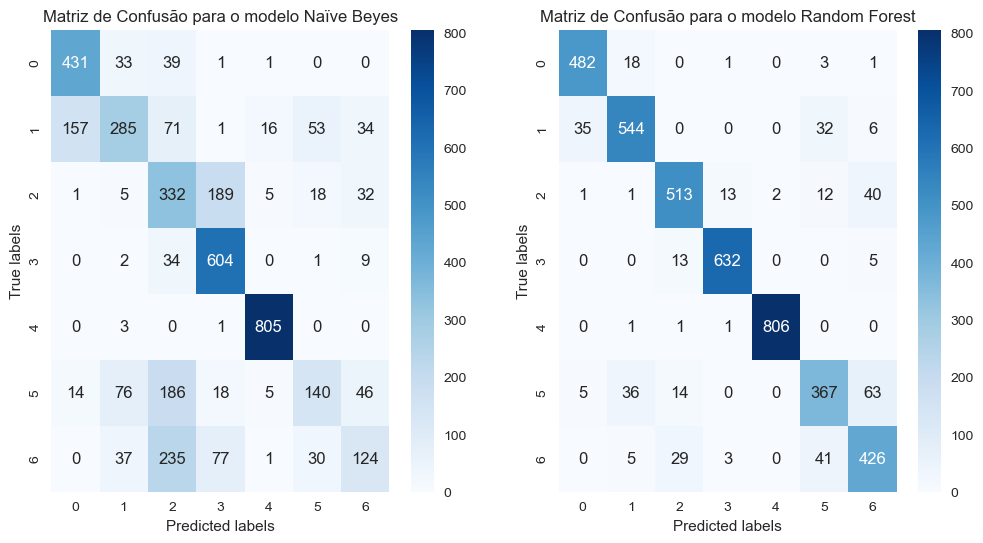

In [46]:
# Decodificando os labels
mapeamento = {
    0: "Insufficient_Weight",
    1: "Normal_Weight",
    2: "Obesity_Type_I",
    3: "Obesity_Type_II",
    4: "Obesity_Type_III",
    5: "Overweight_Level_I",
    6: "Overweight_Level_II"
}
y_predict_naive_bayes = [mapeamento[i] for i in y_predict_naive_bayes]
y_predict_forest = [mapeamento[i] for i in y_predict_forest]
y_test = [mapeamento[i] for i in y_test]

cm_nb = confusion_matrix(y_test, y_predict_naive_bayes)
cm_rf = confusion_matrix(y_test, y_predict_forest)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(cm_nb, annot=True, cmap='Blues', fmt='d', ax=axs[0])
axs[0].set_title('Matriz de Confusão para o modelo Naïve Beyes')
axs[0].set_xlabel('Predicted labels')
axs[0].set_ylabel('True labels')
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='d', ax=axs[1])
axs[1].set_title('Matriz de Confusão para o modelo Random Forest')
axs[1].set_xlabel('Predicted labels')
axs[1].set_ylabel('True labels')

print(f"A acurácia do Naïve Beyes foi de {resultado_naive_bayes}")
print(f"A acurácia do Random Forest foi de {resultado_forest}")

## Classificação do dataset de teste

In [47]:
#  {'max_depth': 40, 'max_features': 5, 'min_samples_leaf': 2, 'n_estimators': 900}
random_forest = RandomForestClassifier(max_depth=40, max_features=5, min_samples_leaf=2, n_estimators=900, n_jobs=-1)
random_forest.fit(features,labels) # treinamento do modelo de Random Forest com o dataset de treinamento completo
y_predict_forest = random_forest.predict(test) # classificação com o modelo Random Forest

### Geração do CSV

In [48]:
mapeamento = {
    0: "Insufficient_Weight",
    1: "Normal_Weight",
    2: "Obesity_Type_I",
    3: "Obesity_Type_II",
    4: "Obesity_Type_III",
    5: "Overweight_Level_I",
    6: "Overweight_Level_II"
}
predict_categorico = [mapeamento[i] for i in y_predict_forest]
resultado = np.column_stack((test_dataset['id'].values, predict_categorico))
np.savetxt('resuldado.csv', resultado, delimiter=',', header="id,NObeyesdad", fmt='%s', comments='')